In [32]:
import os, csv, snappy
from pathlib import Path
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from snappy import HashMap
import gc   
from snappy import GPF
jpy = snappy.jpy
from snappy import ProductIO, File
from snappy import WKTReader
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

In [33]:
##init variables
File = jpy.get_type('java.io.File') #file type   

pc_base_directory = ('C:/Sentinel 3 Data/') 
laptop_base_directory = ('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff')

base_directory = laptop_base_directory
k=0
path = Path(base_directory)
print(path)


C:\Users\Massimo\Documents\SchoolFolder\ThirdYear\Thesis\MassThesis\src\TIF\AllBandsTiff


In [34]:
##Malta polygon
shpMalta = gpd.read_file(r'Malta Shape File/MaltaShapeFile.shp') 
geom=str(shpMalta['geometry'][0])# get the geometry of polygon shapefile as string. 
geom = WKTReader().read(geom) #create WKT file from the Shapefile.


In [35]:
#CSV
def write_to_csv( sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi):
    #print(sat, date_format, sensor, time_format)
    with open('ProcessedDataCSV.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["File Name", "Satellite", "Sensor", "Date", "Time", "LST Mean", "LST Max", "NDVI Mean"])

        for i in range(len(sat)):
            writer.writerow([full_name[i], sat[i], sensor[i], date_format[i], time_format[i], lst_mean[i], lst_max[i], ndvi[i]]) 

##########################################


In [43]:
## Details about Products
full_name = []
product_name = []
sat = []
sensor = []
date_format = []
time_format = []

lst_mean = []
lst_max = []

lst_urb_max = [] #hottest pixel
lst_urb_mean = [] #average temp of study area
lst_sur = [] #average temp of surrounding study area

suhi_max = []
suhi_mean = []

ndvi = []

##########################################

Directory open:
['C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff']
LST mean:
295.2024 Kelvin
22.202392578125 Celcius
Max LST Pixel value: 
298.932 Kelvin
25.9320068359375 Celcius

NDVI mean:
0.38158262


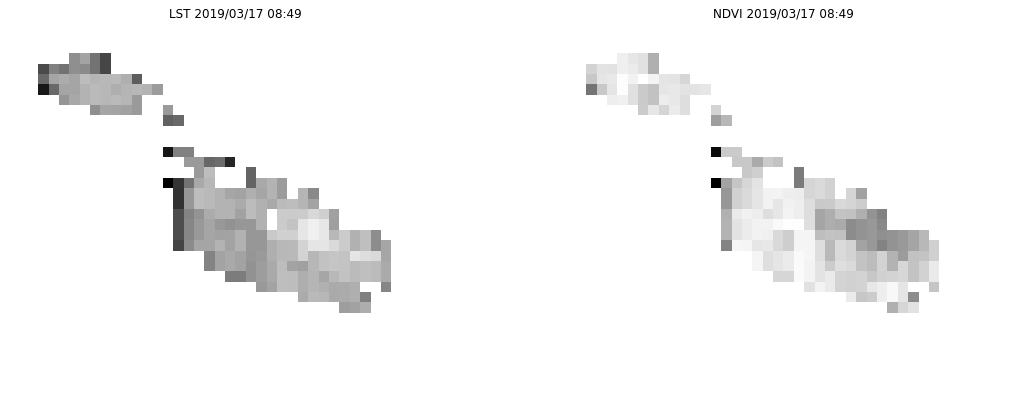

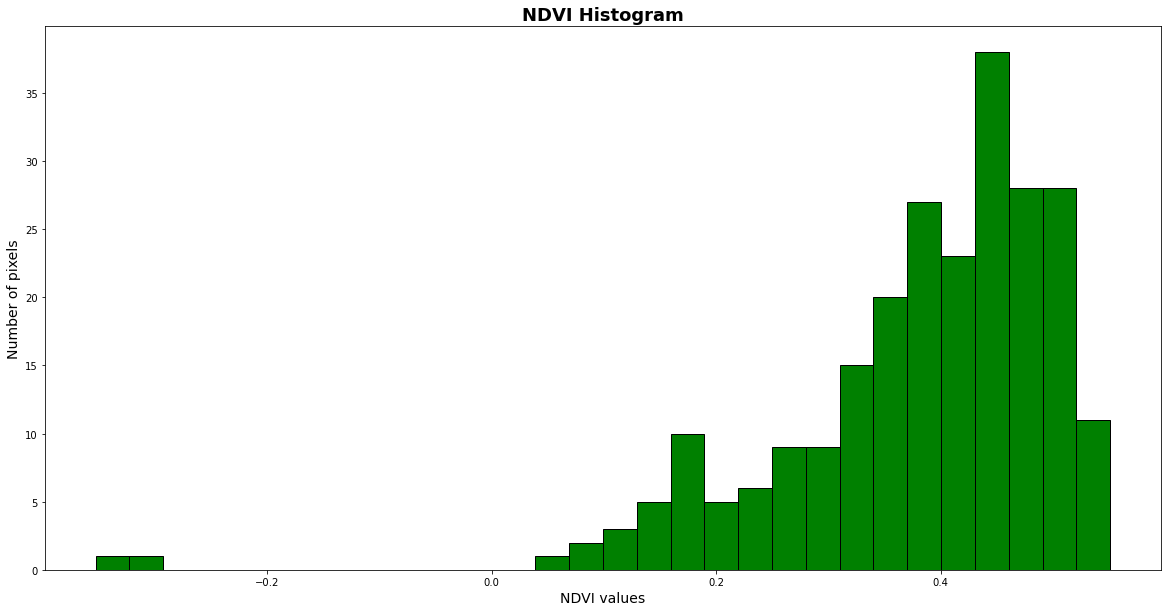

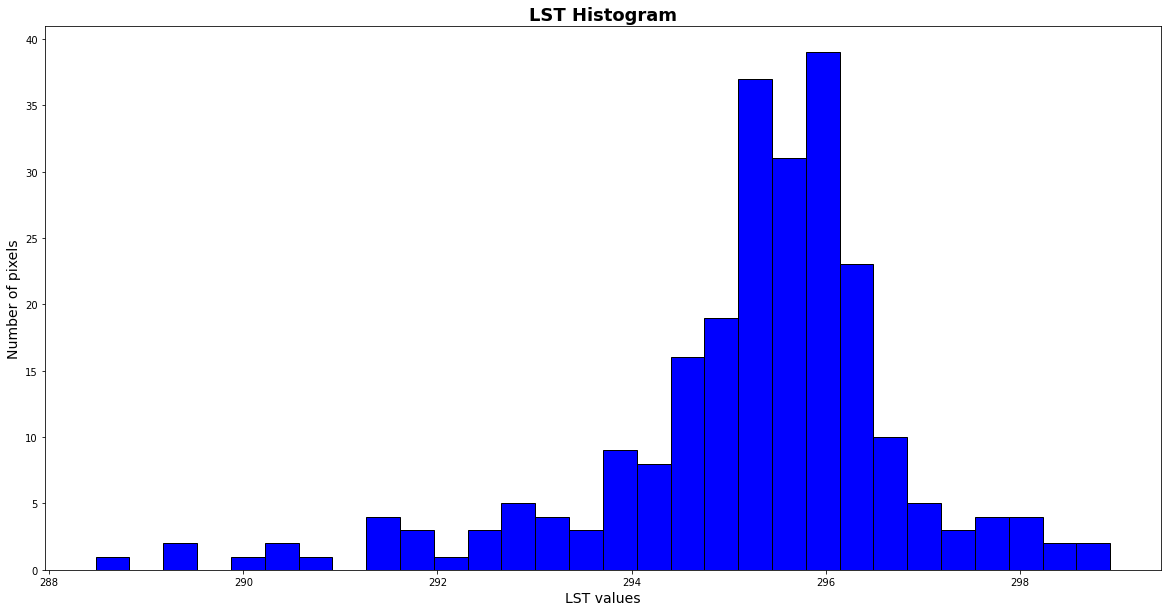

###################
LST mean:
295.8461 Kelvin
22.846099853515625 Celcius
Max LST Pixel value: 
299.78 Kelvin
26.779998779296875 Celcius

NDVI mean:
0.41114858


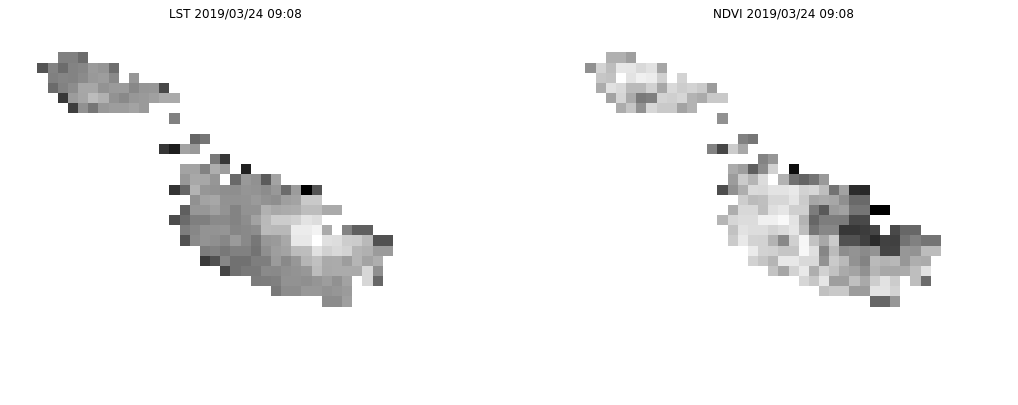

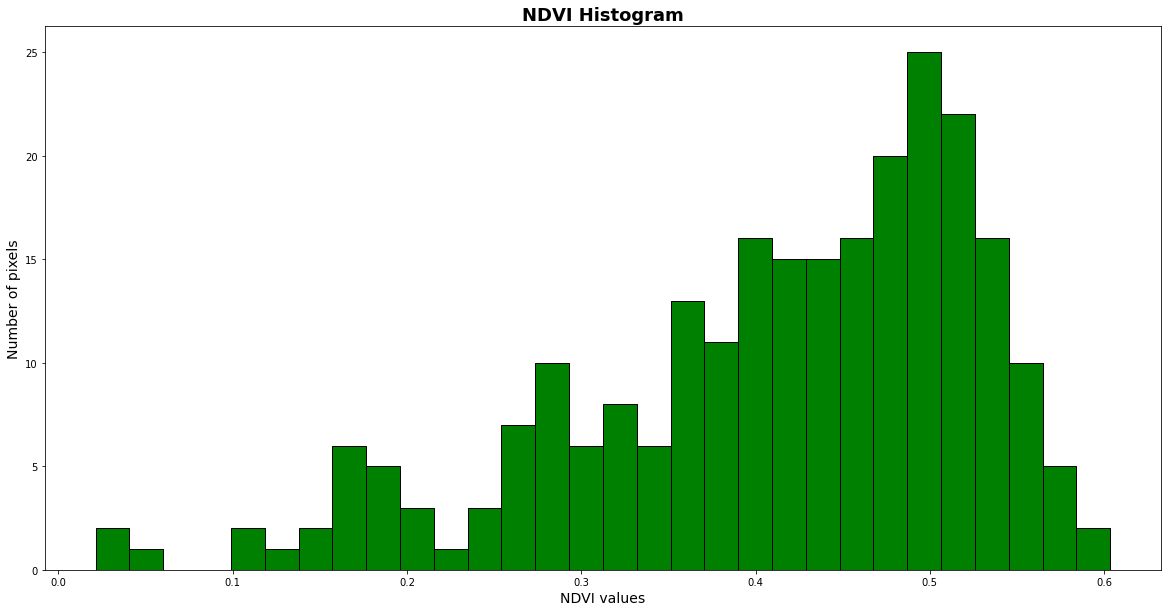

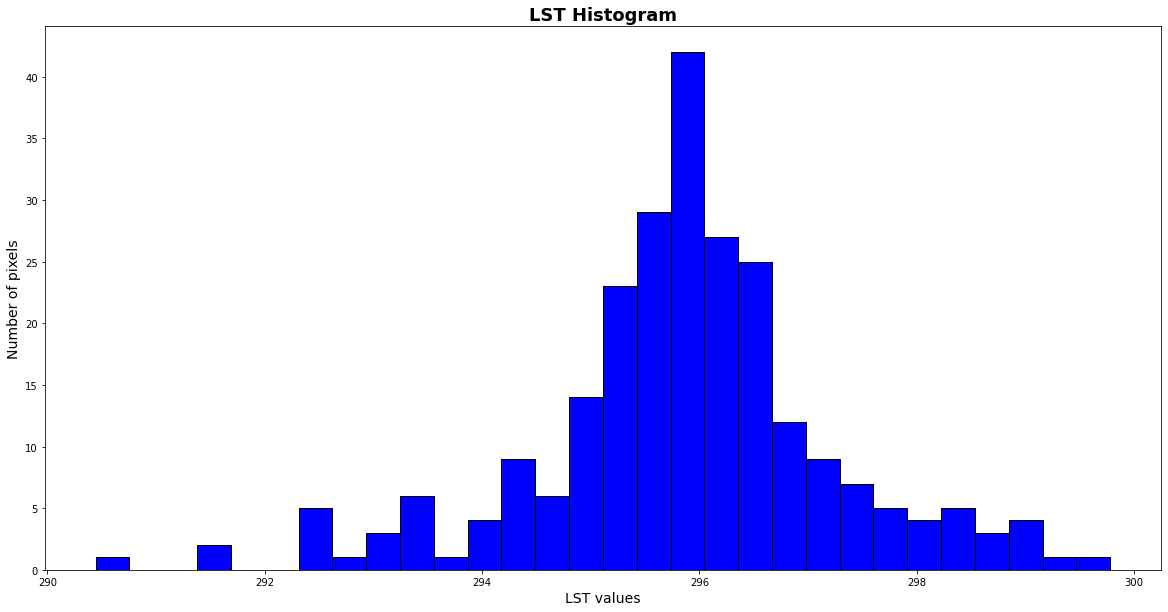

###################
LST mean:
310.99194 Kelvin
37.991943359375 Celcius
Max LST Pixel value: 
316.982 Kelvin
43.98199462890625 Celcius

NDVI mean:
0.19041604


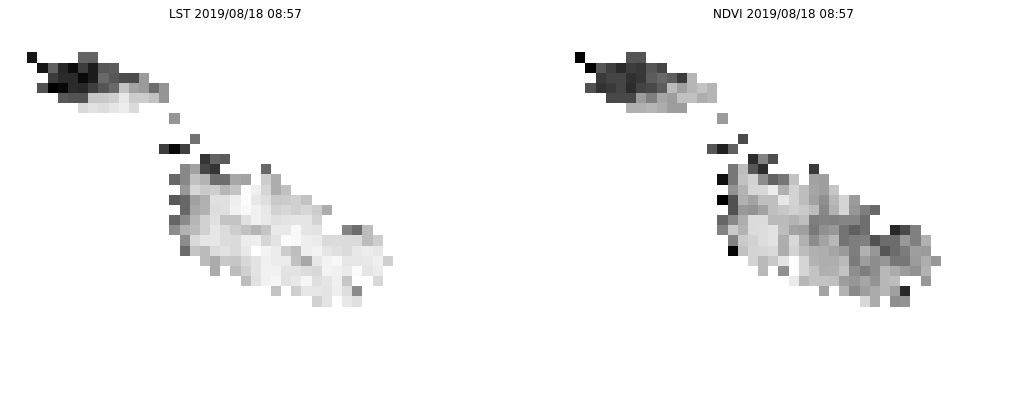

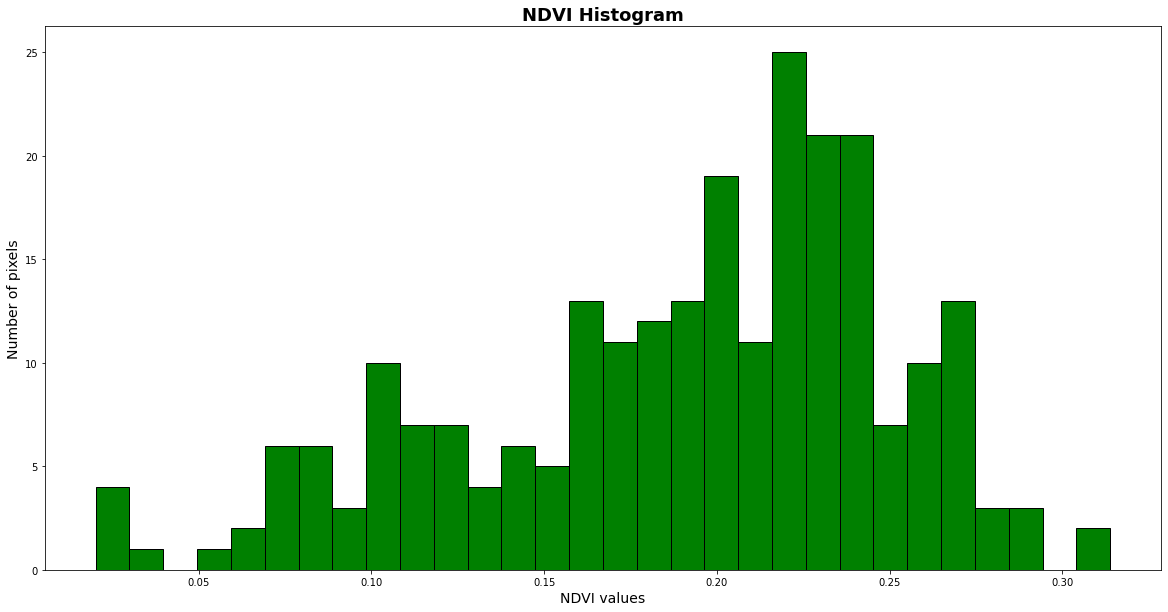

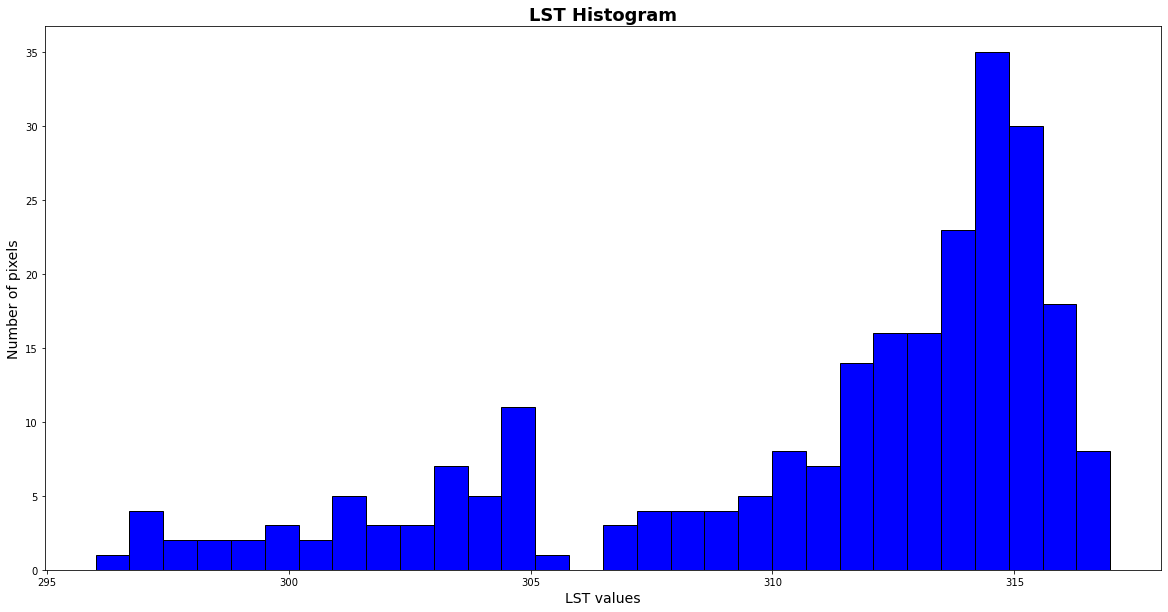

###################
LST mean:
312.79752 Kelvin
39.797515869140625 Celcius
Max LST Pixel value: 
317.172 Kelvin
44.1719970703125 Celcius

NDVI mean:
0.20647804


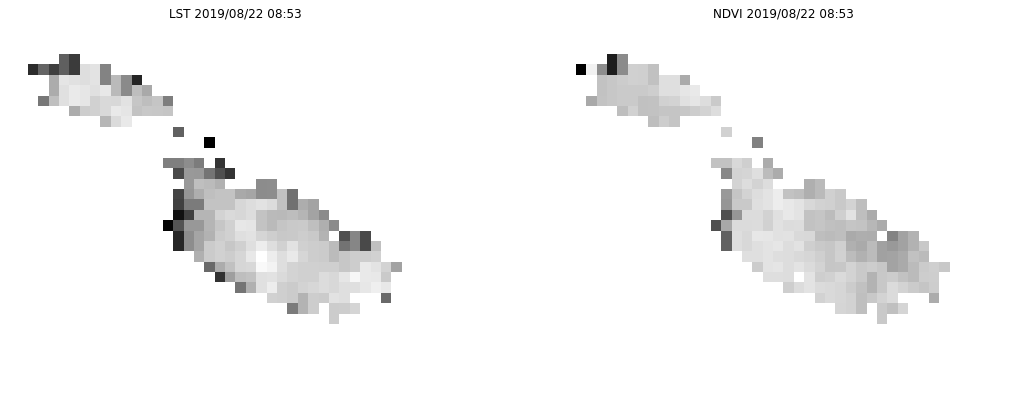

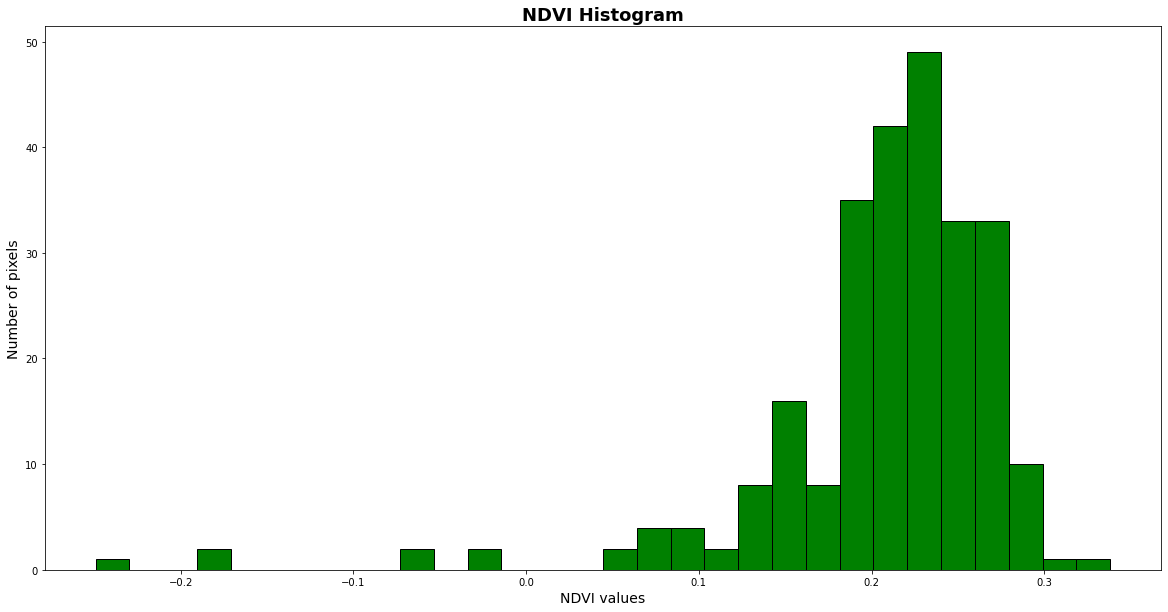

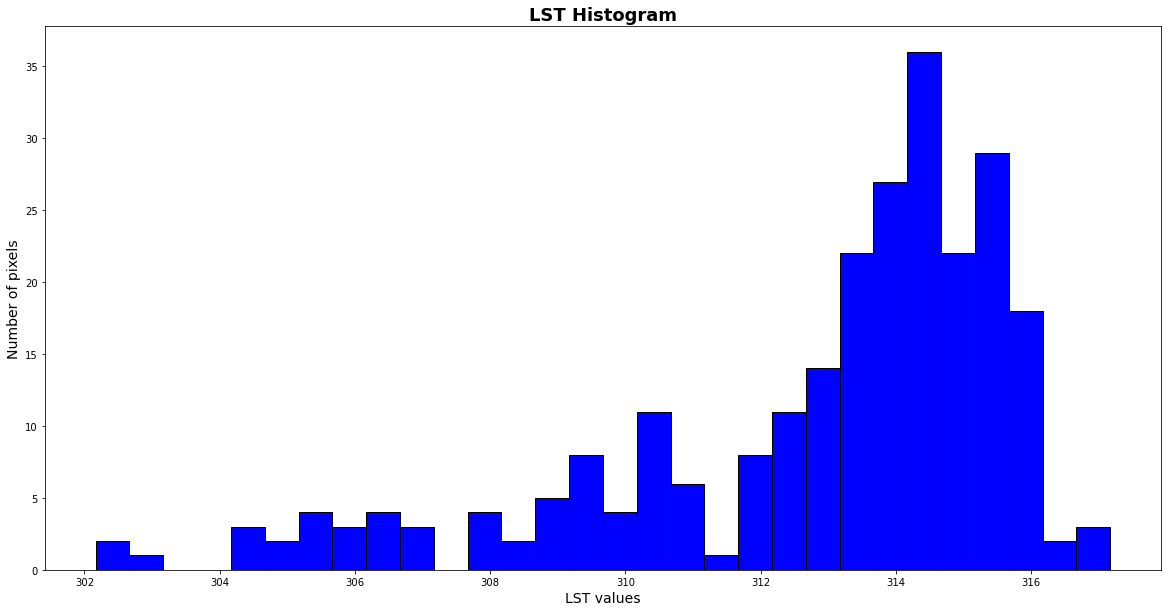

###################
LST mean:
287.64972 Kelvin
14.64971923828125 Celcius
Max LST Pixel value: 
297.402 Kelvin
24.402008056640625 Celcius

NDVI mean:
0.14871918


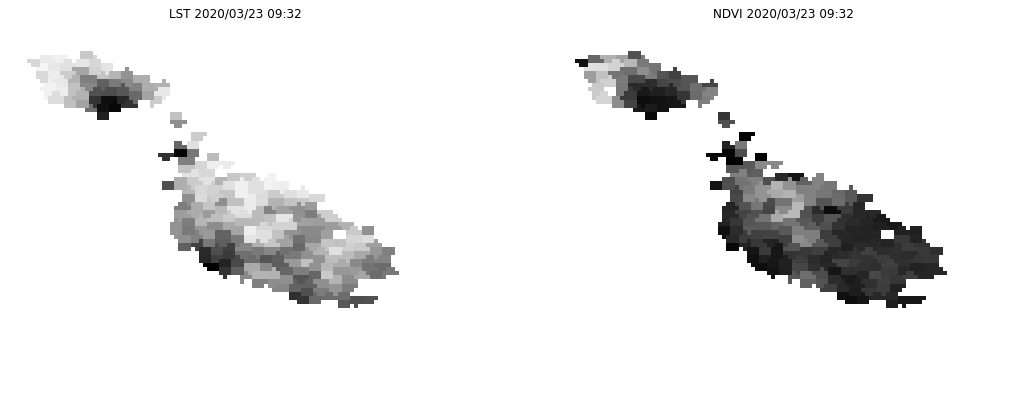

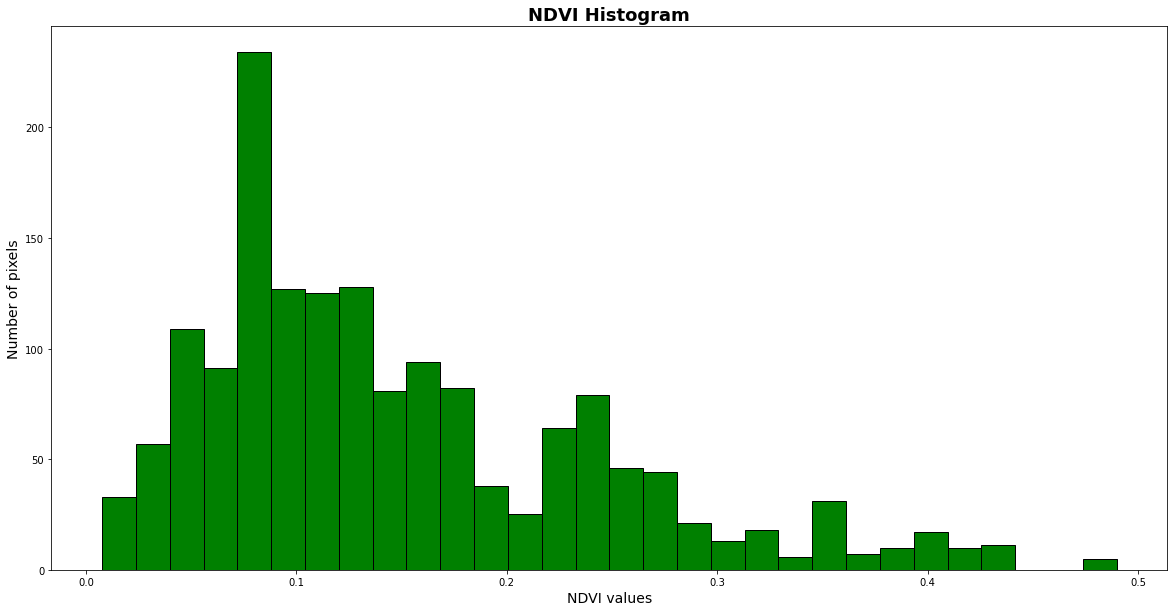

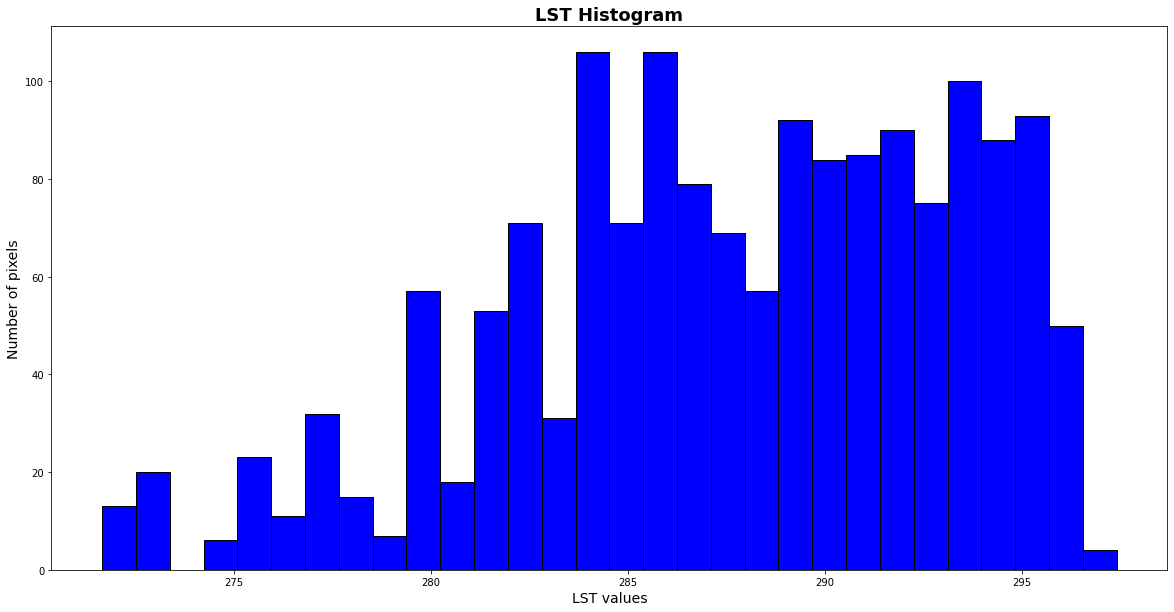

###################
LST mean:
289.93616 Kelvin
16.9361572265625 Celcius
Max LST Pixel value: 
298.604 Kelvin
25.60400390625 Celcius

NDVI mean:
0.20617442


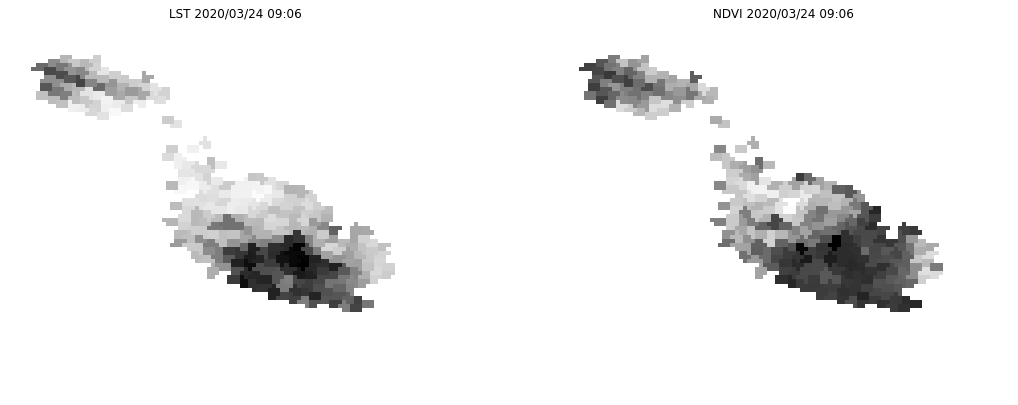

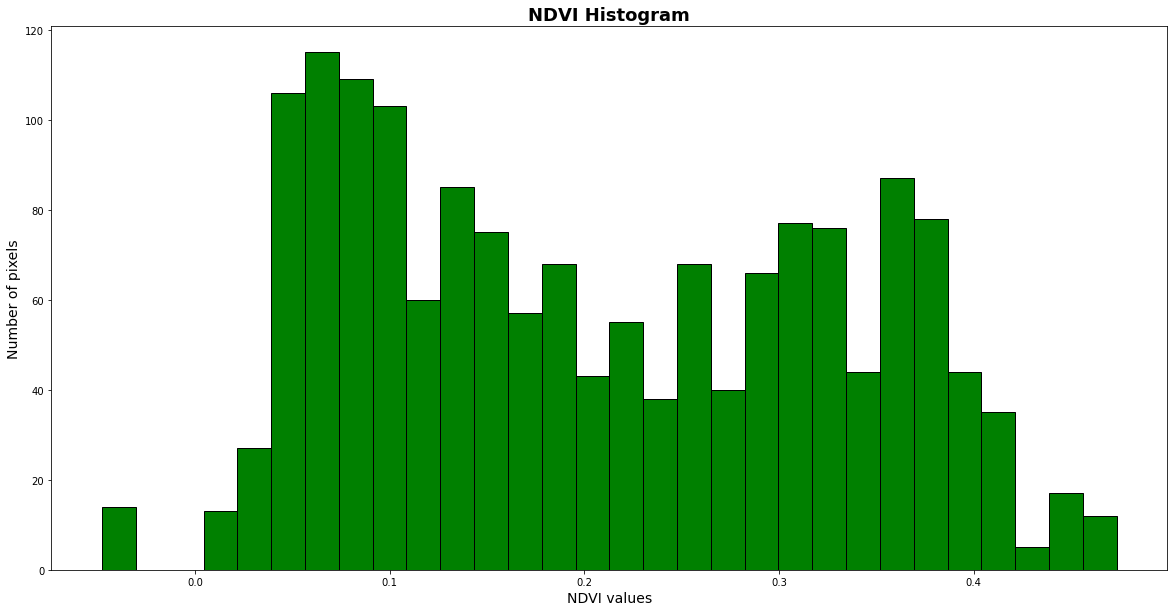

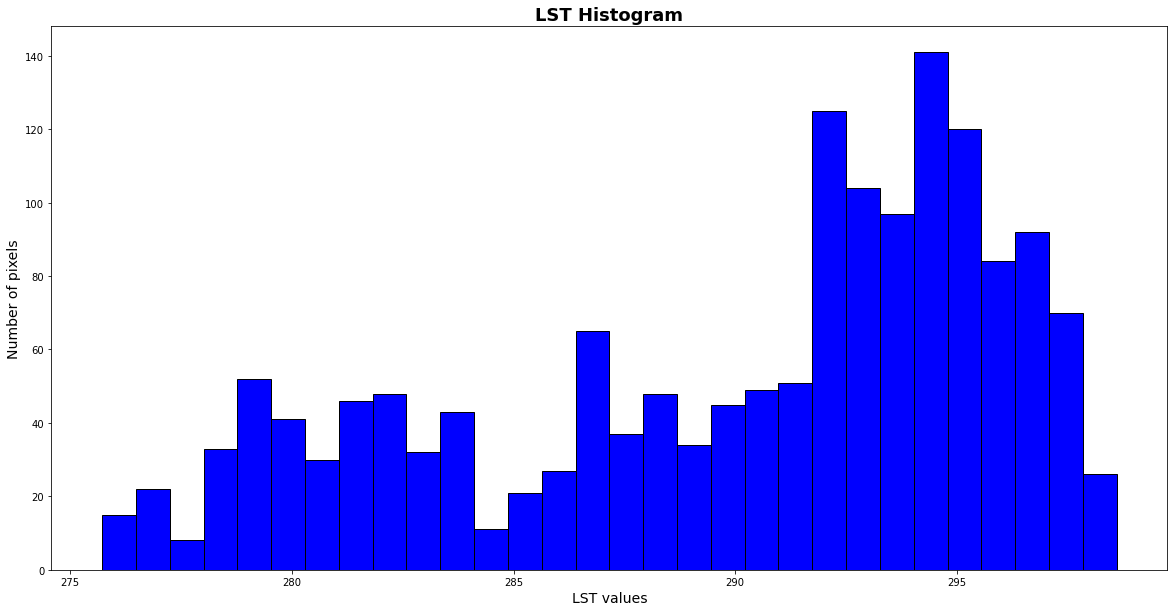

###################


In [44]:
for root, dirs, files in os.walk(base_directory):
    path = root.split(os.sep)

    #print(os.path.join(root, name))

    print('Directory open:')
    print(path)
    #print('\n\nProduct Names:')    
    
    ###Gathering Product details such as date & time and storing them
    for name in files:
        full_name.append(str(name))

        temp_product = str(name)[17:46] #30chars include: (0-2)Sat, (4-8)Sensor, (13-31)Type, Year, Month, Date, Time
        product_name.append(temp_product) 

        sat.append(temp_product[:3])
        sensor.append(temp_product[4:12])

        date = temp_product[16:24]
        date = date[:4] + '/' + date[4:6] + '/' + date[6:]
        date_format.append(date)

        time = temp_product[25:29]
        time = time[:2] + ':' + time[2:]
        time_format.append(time)

        ####
        ####
        #product to be used
        product_path = str(os.path.join(root, name))
        archi=File(product_path)

        product = ProductIO.readProduct(archi)
        reader = snappy.ProductIO.getProductReader('SEN3')

        ##Subset to Malta
        par = HashMap()
        par.put('copyMetadata', True)
        par.put('geoRegion', geom)
        product = GPF.createProduct('Subset', par, product) #Spatial subset.
        
        # Get LST Band
        lst_band = product.getBand('LST')
        lst_w = product.getSceneRasterWidth() # Get Band Width
        lst_h = product.getSceneRasterHeight() # Get Band Height

        # Get NDVI Band
        ndvi_band = product.getBand('NDVI')
        ndvi_w = product.getSceneRasterWidth() # Get Band Width
        ndvi_h = product.getSceneRasterHeight() # Get Band Height

        # Create empty arrays
        lst_band_data = np.zeros(lst_w * lst_h, np.float32)
        ndvi_band_data = np.zeros(ndvi_w * ndvi_h, np.float32)

        # Populate arrays with pixel value
        lst_band.readPixels(0, 0, lst_w, lst_h, lst_band_data) 
        ndvi_band.readPixels(0, 0, ndvi_w, ndvi_h, ndvi_band_data)

        # Reshape
        lst_band_data.shape = lst_h, lst_w
        ndvi_band_data.shape = ndvi_h, ndvi_w

        ##Collecting Data
        #LST
        no_nan_lst_band_data = lst_band_data[~np.isnan(lst_band_data)]
        print('LST mean:')
        mean = np.mean(no_nan_lst_band_data)
        print(str(mean) + ' Kelvin')
        print(str(mean - 273) + ' Celcius')
        lst_mean.append(mean)

        print('Max LST Pixel value: ')
        max = np.amax(no_nan_lst_band_data)
        print(str(max) + ' Kelvin')
        print(str((max - 273)) + ' Celcius')
        lst_max.append(max)

        #NDVI
        no_nan_ndvi_band_data = ndvi_band_data[~np.isnan(ndvi_band_data)]
        print('\nNDVI mean:')
        mean = np.mean(no_nan_ndvi_band_data)
        print(str(mean))        
        ndvi.append(mean)

        ##
        ##Heatmap colours
        color = cm.jet
        color.set_bad('white')
        # Plot the band  
        plt.figure(figsize=(18,10))
        plt.subplot(121)
        #plt.imshow(lst_band_data, cmap=color), plt.title('LST')
        plt.imshow(lst_band_data, cmap= 'gray'), plt.title('LST ' + date + ' ' + time)
        plt.axis('off')
        plt.subplot(122)
        #plt.imshow(ndvi_band_data, cmap =color), plt.title('NDVI')
        plt.imshow(ndvi_band_data, cmap = 'gray'), plt.title('NDVI ' + date + ' ' + time)
        plt.axis('off')
        plt.show()

        ####
        #Histogram
        #NDVI
        # Define a new figure
        fig2 = plt.figure(figsize=(20,10))
        # Give this new figure a subplot, which will contain the histogram itself
        ax = fig2.add_subplot(111)

        # Add a title & (x,y) labels to the plot
        plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
        plt.xlabel("NDVI values", fontsize=14)
        plt.ylabel("Number of pixels", fontsize=14)

        # For the x-axis, we want to count every pixel that is not an empty value
        x = no_nan_ndvi_band_data
        color = 'g'
        # call 'hist` with our x-axis, bins, and color details
        ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

        # Save the generated figure to an external image file
        #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
        plt.show()

        #LST
        # Define a new figure
        fig3 = plt.figure(figsize=(20,10))
        # Give this new figure a subplot, which will contain the histogram itself
        ax = fig3.add_subplot(111)

        # Add a title & (x,y) labels to the plot
        plt.title("LST Histogram", fontsize=18, fontweight='bold')
        plt.xlabel("LST values", fontsize=14)
        plt.ylabel("Number of pixels", fontsize=14)

        # For the x-axis, we want to count every pixel that is not an empty value
        x = no_nan_lst_band_data
        color = 'b'
        # call 'hist` with our x-axis, bins, and color details
        ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

        # Save the generated figure to an external image file
        #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
        plt.show()

        print('###################')

In [39]:
write_to_csv(sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi)